In [1]:
import os
import pandas as pd
import numpy as np
from utils import (
    coverage_dowmonth,
    coverage_mthyr,
    save_mpl_fig,
    its, 
    plotline, 
    plot_dual_indices
)

FP = '../data/cnn_2000_2021_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

### Data Coverage

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(year=lambda df: np.where(df.year==3007, 2007,df.year))
      .assign(date=lambda df: pd.to_datetime(dict(year=df.year, month=df.month, day=df.date)))
      .groupby(['date']).size().reset_index()
      .rename(columns={0:'obs'})
      .assign(year=lambda df: [dt64.year for dt64 in df.date])
     )
df.head(3)

,date,obs,year
0,2000-01-01,72,2000
1,2000-01-02,40,2000
2,2000-01-03,67,2000


D:\readable_news\scripts\utils.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=figsize)


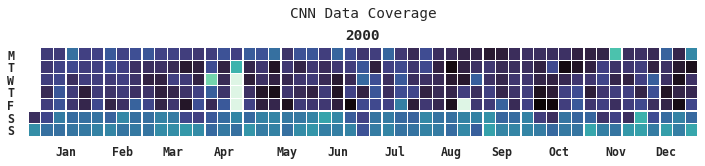

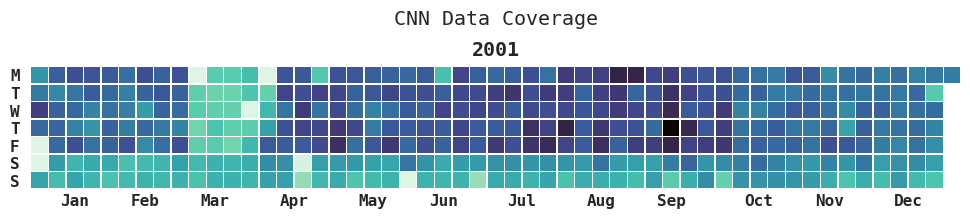

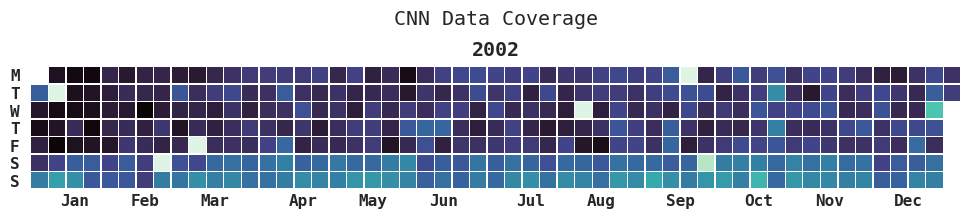

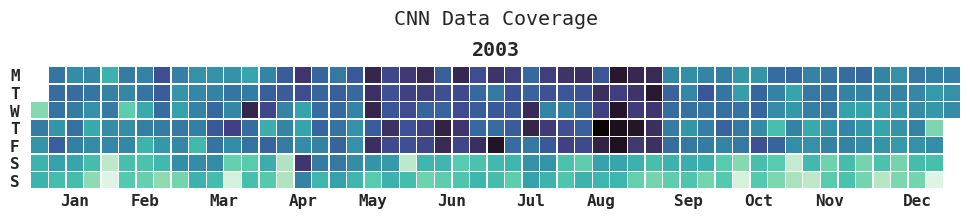

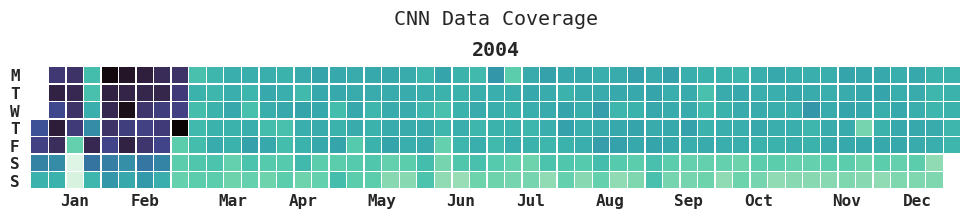

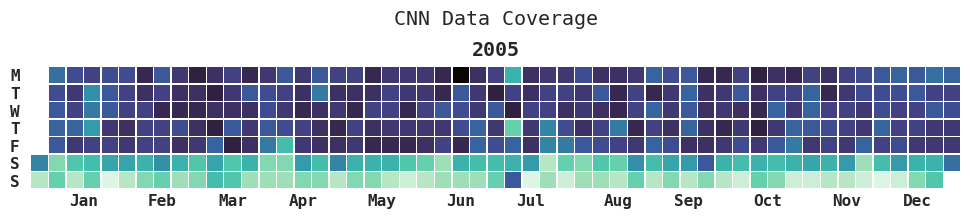

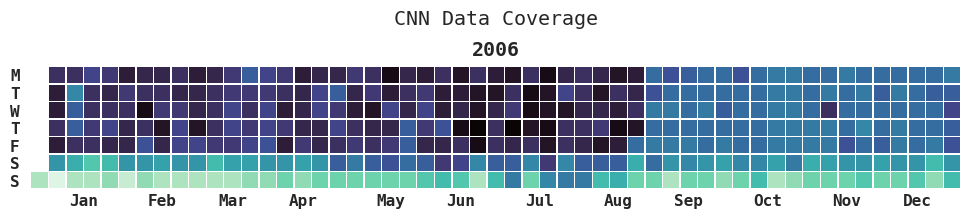

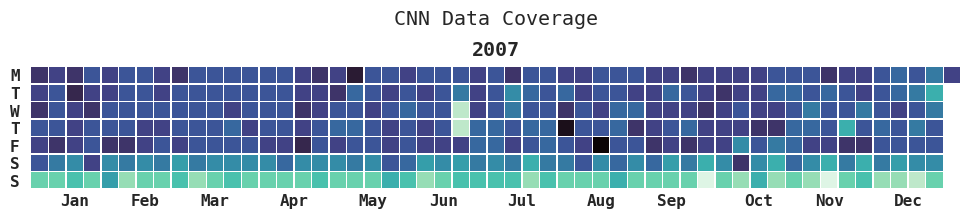

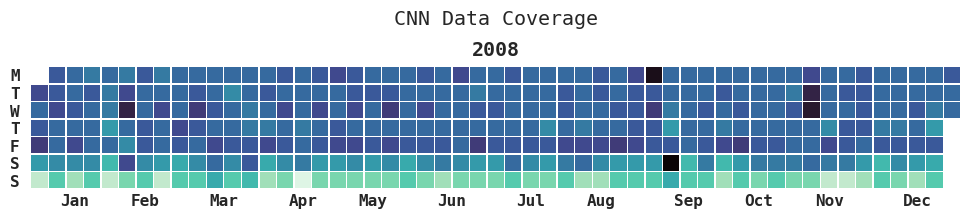

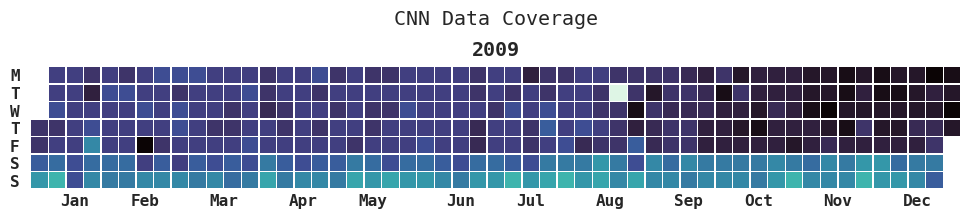

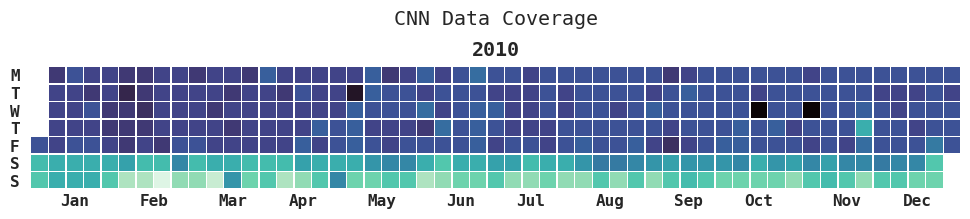

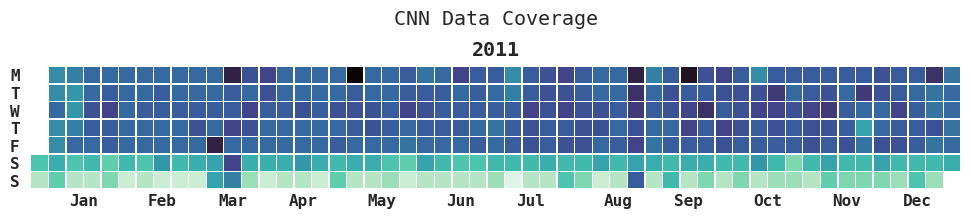

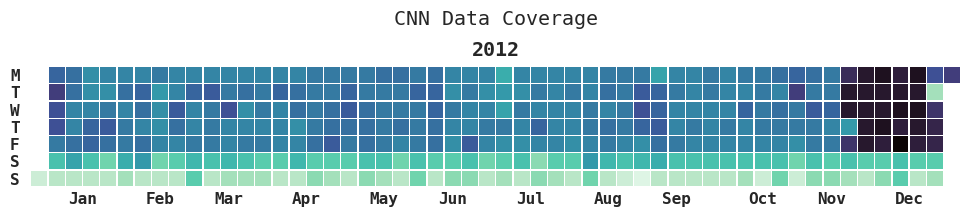

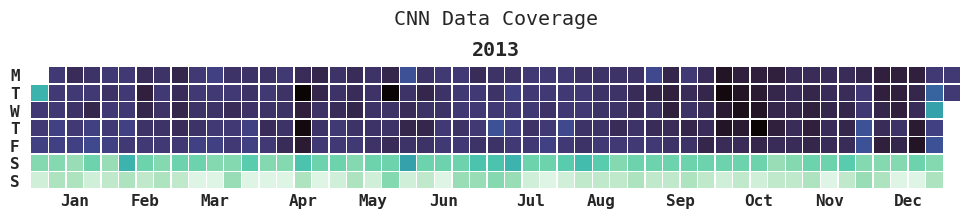

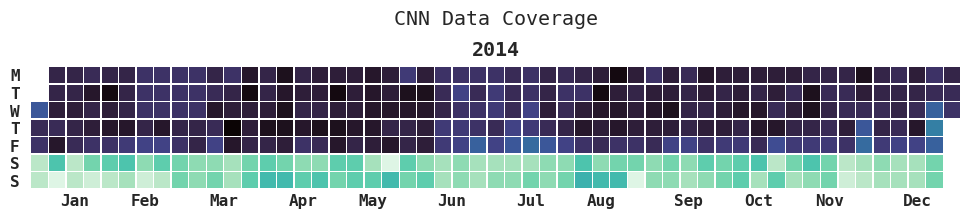

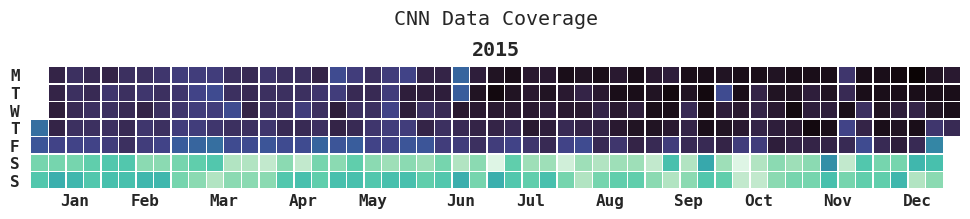

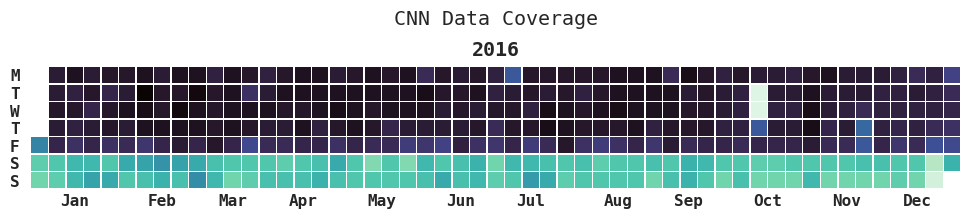

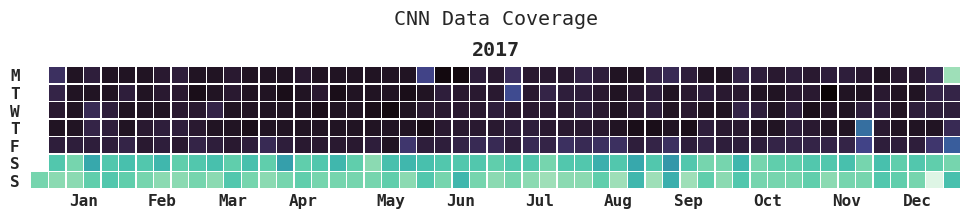

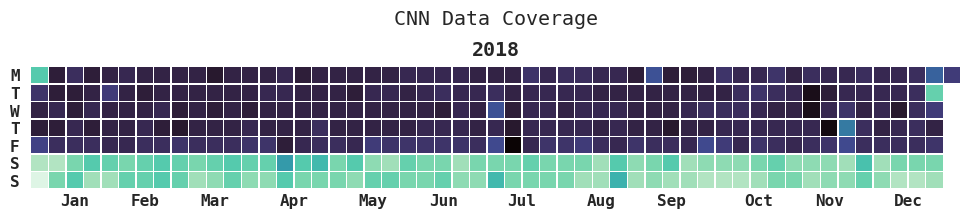

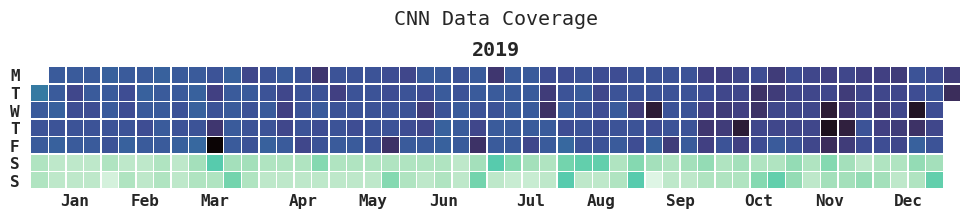

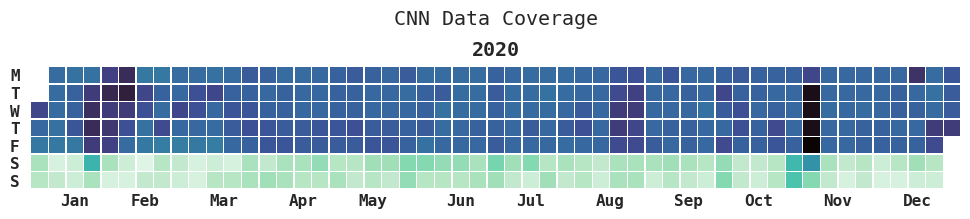

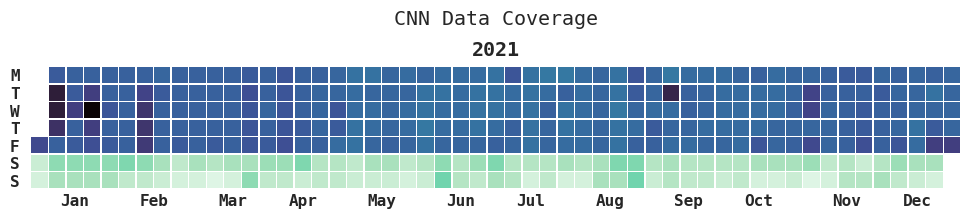

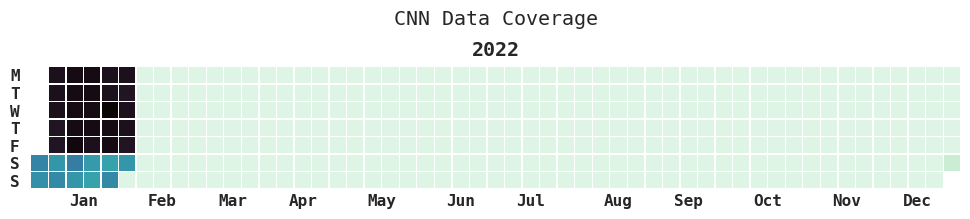

In [3]:
for year in df.year.unique():
    _df = df.query('year==@year')
    coverage_dowmonth(_df.date, _df.obs, title='CNN Data Coverage')
    save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/cnn_dowmonth_{year}'))

In [4]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(year=lambda df: np.where(df.year==3007, 2007,df.year))
      .assign(date=lambda df: pd.to_datetime(dict(year=df.year, month=df.month, day=df.date)))
      .set_index('date').groupby(pd.Grouper(freq='M')).size().reset_index()
      .rename(columns={0: 'count'})
      .assign(month=lambda df: [dt64.month_name()[:3] for dt64 in df.date],
              monthix=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date])
      .pivot(['month', 'monthix'], 'year', 'count')
      .sort_values('monthix').droplevel('monthix')
     )
df.head(3)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
Jan,1906,2084,2210,1898,1461,701,708,642,621,618,...,1001,1036,994,1099,1109,1094,1108,1331,1266,1134
Feb,1757,1922,1914,1616,1540,710,670,563,581,568,...,928,904,894,1122,1016,1012,985,1154,1109,193
Mar,2016,1110,1918,1938,746,798,718,611,623,626,...,977,1017,938,1184,1148,1114,1104,1232,1224,0


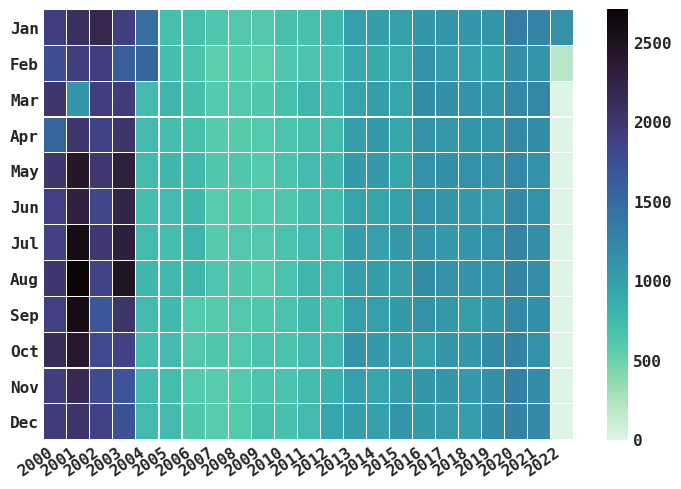

In [5]:
coverage_mthyr(df, xtickangle=35)
save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/cnn_monthyear'))

### Readability & Lexical Richness

In [6]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
#       .assign(cnnint=lambda df: np.where(df['program.name'].str.contains('international', case=False), 1,0))
#       .query('cnnint==1')
      .drop('timezone', axis=1) # always ET
      # Set date
      .assign(
          year=lambda df: np.where(df.year==3007, 2007,df.year),
          mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
      )
      # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100')
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,year,month,date,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd
0,2000-01-01,2000.0,1.0,15.925554,45.496589,16.137012,17.222904,13.899525,1428.580253,445.514256,0.427960,91.942097,0.859716
1,2000-02-01,2000.0,2.0,14.932990,44.620584,16.312715,17.362308,14.018385,1333.118557,424.422108,0.432992,91.251091,0.859605
2,2000-03-01,2000.0,3.0,16.118000,44.586265,16.211350,17.239195,13.916600,1186.820000,390.902500,0.446421,89.317664,0.859811


In [7]:
xticklabels=range(2000, 2023, 3)

<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

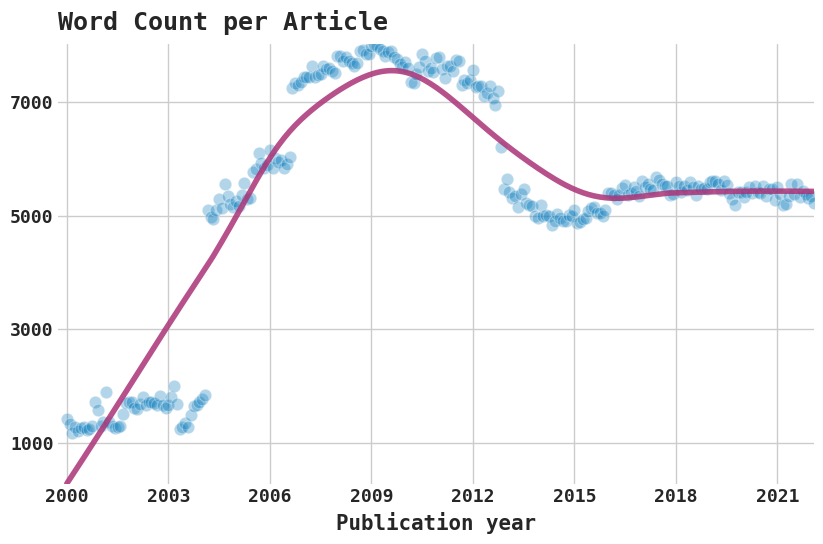

In [8]:
plotline(x=df.index, y=df.terms, xticklabels=xticklabels,
         yrange=range(1000,8000,2000), 
         title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'cnn_wordcount')
        )    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

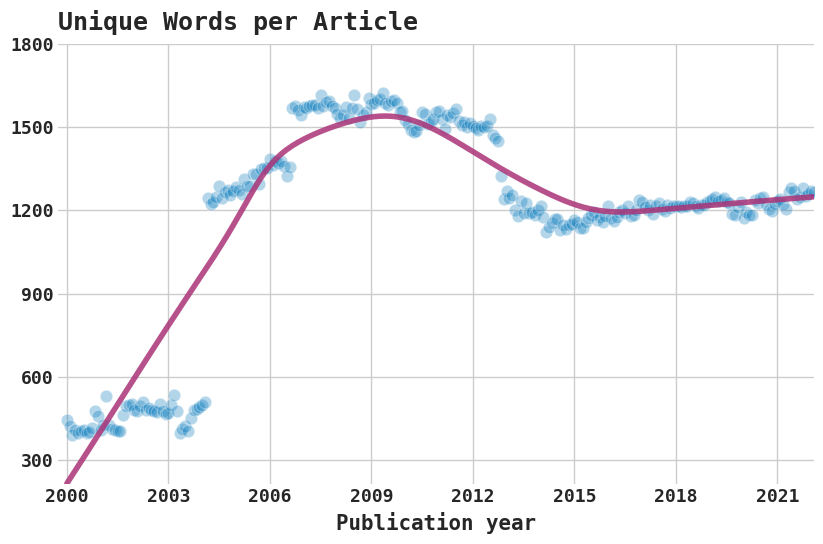

In [9]:
plotline(x=df.index, y=df.uniqueterms, xticklabels=xticklabels, 
         yrange=range(300,2000,300), 
         title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'cnn_uniquewords')
        ) 

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

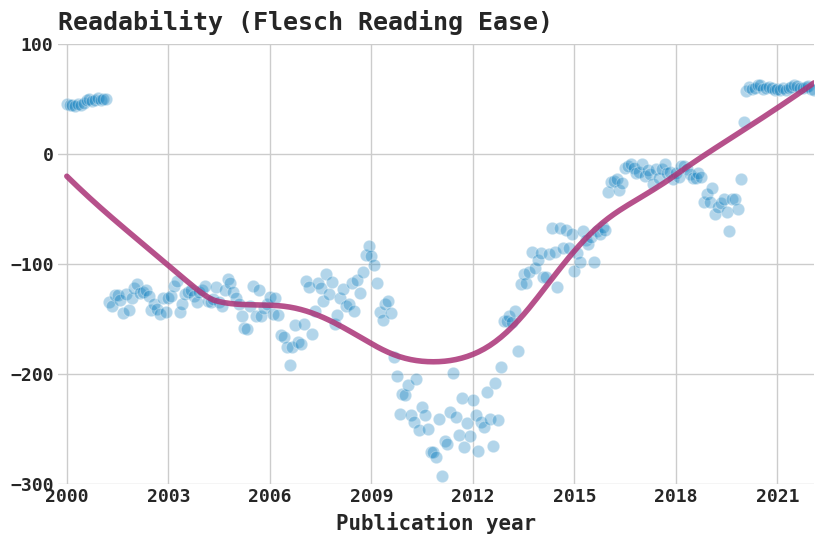

In [10]:
plotline(x=df.index, y=df.flesch_reading_ease, xticklabels=xticklabels, 
         yrange=range(-300,200,100), 
         title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'cnn_readability_flesch_ease')
        )    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

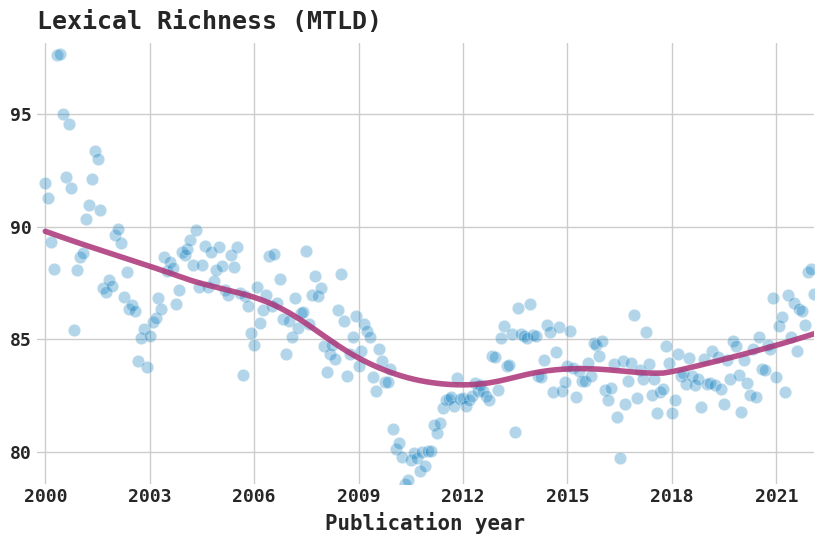

In [11]:
plotline(x=df.index, y=df.mtld, xticklabels=xticklabels, 
         yrange=range(80,100,5), 
         title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'cnn_lexicalrichness_mtld')
        )

In [12]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
       .drop('timezone', axis=1) # always ET
       .assign(
           year=lambda df: np.where(df.year==3007, 2007,df.year),
           mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
       )
       # Drop outliers by length
       .pipe(lambda df: 
             df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
       .query(f'terms>100')     
       .groupby(['year']).mean().reset_index()
       .assign(
           iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
           ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
           imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
           ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
           iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
           iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
              )
     )
idf.head(3)

,year,month,date,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2000.0,6.587450,15.703741,47.022478,15.615247,16.676153,13.679478,1340.426784,419.281805,0.429905,91.968163,0.861091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2001.0,6.791911,15.819168,-98.660516,68.808618,69.497397,18.686145,1458.075906,443.911175,0.411125,89.819344,0.860927,-309.815645,36.599839,-2.336482,-4.368393,8.776990,5.874181
2,2002.0,6.345765,15.738882,-131.719374,80.880014,81.387721,21.118604,1693.738306,484.187190,0.389542,86.855730,0.860354,-380.120016,54.381647,-5.558916,-9.388948,26.358137,15.480134


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change from 2000'>

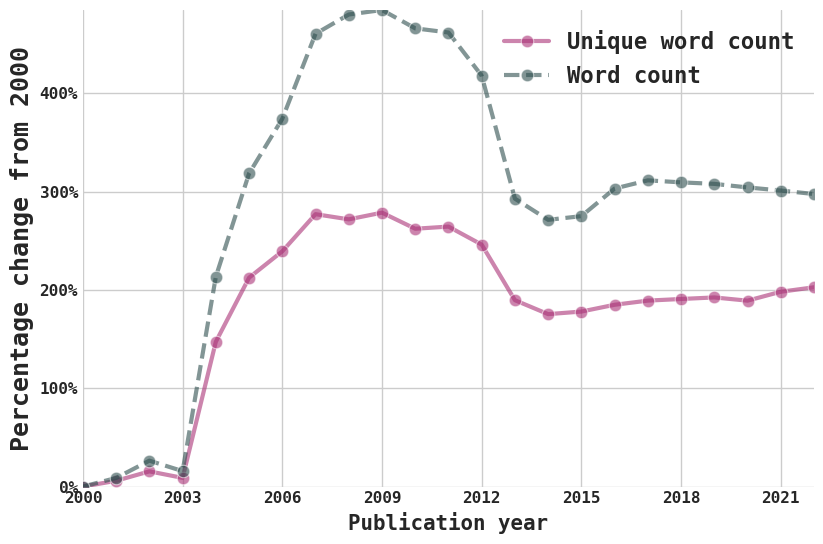

In [16]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, 
                  label1='Unique word count', label2='Word count', 
                  ylabel='Percentage change from 2000', xrange=xticklabels,
                  savepath=os.path.join(SAVEPATH, 'cnn_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change from 2000'>

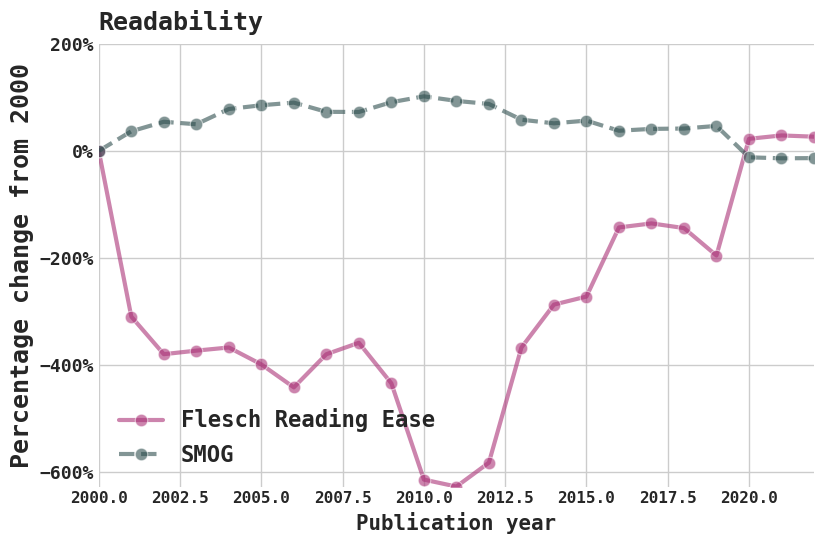

In [14]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, 
                  yrange=range(-600,400,200), 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  ylabel='Percentage change from 2000', xrange=xticklabels,
                  savepath=os.path.join(SAVEPATH, 'cnn_readability_index')
                 )    

<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 2000'>

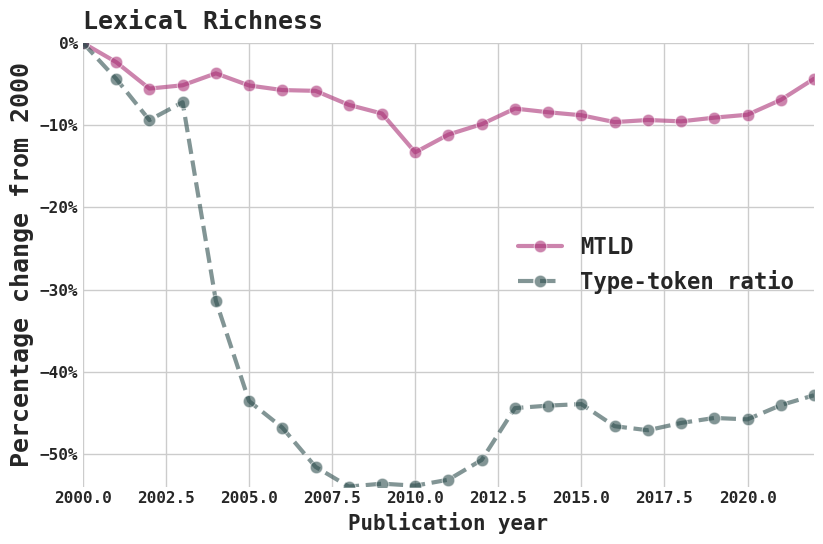

In [15]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  ylabel='Percentage change from 2000', xrange=xticklabels,
                  savepath=os.path.join(SAVEPATH, 'cnn_lexicalrichness_index')
                 )    